In [25]:
from collections.abc import Sequence
from sklearn import preprocessing
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from scipy.stats import zscore
import pandas as pd
import json
import csv
import io
import requests
import shutil
import os
import numpy as np
from sklearn import metrics
path = "./yelp_dataset/"



In [26]:
#Import helper functions

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low




In [27]:
#Read review data from json file

outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars','text'])
filename_read = os.path.join(path,"yelp_academic_dataset_review.json")
lineCount = 0

with open(filename_read, encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'],row['stars'],(row['text']).encode('utf-8')])
        #lineCount += 1
        #if lineCount >= 1000:
         #   break;
        
outfile.close()

df_review=pd.read_csv('review_stars.tsv',delimiter="\t",encoding="utf=8")

df_review[0:5]

,business_id,stars,text
0,buF9druCkbuXLX526sGELQ,4.0,"b""Apparently Prides Osteria had a rough summer..."
1,RA4V8pr014UyUbDvI-LW2A,4.0,b'This store is pretty good. Not as great as W...
2,_sS2LBIGNT5NQb6PD1Vtjw,5.0,"b""I called WVM on the recommendation of a coup..."
3,0AzLzHfOJgL7ROwhdww2ew,2.0,"b""I've stayed at many Marriott and Renaissance..."
4,8zehGz9jnxPqXtOc7KaJxA,4.0,"b""The food is always great here. The service f..."


In [28]:
#Read business data from json file

outfile = open("business_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars','review_count'])
filename_read = os.path.join(path,"yelp_academic_dataset_business.json")
lineCount = 0

with open(filename_read, encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'],row['stars'],row['review_count']])
        #lineCount += 1
        #if lineCount >= 1000:
         #   break;
        
outfile.close()

df_business=pd.read_csv('business_stars.tsv',delimiter="\t",encoding="utf=8")

df_business = df_business[df_business['review_count'] >= 20]

df_business[0:5]

,business_id,stars,review_count
0,6iYb2HFDywm3zjuRg0shjw,4.0,86
1,tCbdrRPZA0oiIYSmHG3J0w,4.0,126
5,D4JtQNTI4X3KcbzacDJsMw,3.5,169
8,N3_Gs3DnX4k9SgpwJxdEfw,5.0,30
12,HPA_qyMEddpAEtFof02ixg,4.0,39


In [52]:
#Match reviews with businesses
df=pd.merge(df_business, df_review, how='inner', on='business_id')

#Remove reviews with no business (business has less than 20 reviews)
df.dropna(axis=0, how='any', inplace=True)

df[0:5]

,business_id,stars_x,review_count,stars_y,text
0,6iYb2HFDywm3zjuRg0shjw,4.0,86,5.0,"b""Stopped in on a busy Friday night. Despite t..."
1,6iYb2HFDywm3zjuRg0shjw,4.0,86,2.0,"b""Went there about 1 PM on a Monday. It wasn'..."
2,6iYb2HFDywm3zjuRg0shjw,4.0,86,5.0,"b""This was the place the be on Friday Night! I..."
3,6iYb2HFDywm3zjuRg0shjw,4.0,86,4.0,"b""Went to this place with my family over the w..."
4,6iYb2HFDywm3zjuRg0shjw,4.0,86,4.0,"b""Stopped on a midweek afternoon, and so glad ..."


In [30]:
#Remove review_count from DataFrame
df.drop('review_count', axis=1, inplace=True)

df[0:5]

,business_id,stars_x,stars_y,text
0,6iYb2HFDywm3zjuRg0shjw,4.0,5.0,"b""Stopped in on a busy Friday night. Despite t..."
1,6iYb2HFDywm3zjuRg0shjw,4.0,2.0,"b""Went there about 1 PM on a Monday. It wasn'..."
2,6iYb2HFDywm3zjuRg0shjw,4.0,5.0,"b""This was the place the be on Friday Night! I..."
3,6iYb2HFDywm3zjuRg0shjw,4.0,4.0,"b""Went to this place with my family over the w..."
4,6iYb2HFDywm3zjuRg0shjw,4.0,4.0,"b""Stopped on a midweek afternoon, and so glad ..."


In [31]:
#Group review text with business_id and prepare DataFrame for sklearn
df_review_agg = df.groupby('business_id')['text'].sum()
df_ready_for_sklearn=pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

In [32]:
#Create TF-IDF Vectorizer and teach with reviews
import time
start_time=time.time()
vectorizer = sk_text.TfidfVectorizer(
    stop_words='english',
    max_features=1000, 
    min_df=1)
matrix = vectorizer.fit_transform(df_ready_for_sklearn.all_reviews)
print(f"Finished in {time.time() - start_time} seconds")

Finished in 933.1395535469055 seconds


In [41]:
#Turn Vectorizer matrix into array usable with TensorFlow
tfidf_data = matrix.toarray()

In [42]:
#Print shape for validation
tfidf_data.shape

(73031, 1000)

In [53]:
#Create array of business star values
y = df_business.stars.values.astype(np.float32)

#Print array size for validation
y.size

73031

In [50]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(tfidf_data, y, test_size=0.25, random_state=42)

In [45]:
#Build model
model = Sequential()

#Create layers
model.add(Dense(20, input_dim=tfidf_data.shape[1], activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))

#Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

#Define early stopping parameters
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

#Fit data
model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=128, callbacks=[monitor], verbose=2, epochs=1000)  


Epoch 1/1000
428/428 - 1s - loss: 2.1346 - val_loss: 0.6706
Epoch 2/1000
428/428 - 1s - loss: 0.6724 - val_loss: 0.6645
Epoch 3/1000
428/428 - 1s - loss: 0.6721 - val_loss: 0.6645
Epoch 4/1000
428/428 - 1s - loss: 0.6721 - val_loss: 0.6645
Epoch 5/1000
428/428 - 1s - loss: 0.6720 - val_loss: 0.6644
Epoch 6/1000
428/428 - 1s - loss: 0.6719 - val_loss: 0.6644
Epoch 7/1000
428/428 - 1s - loss: 0.6719 - val_loss: 0.6644
Epoch 00007: early stopping


In [46]:
# Predict
pred = model.predict(x_test)

# Measure MSE error.  
MSEscore = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(MSEscore))
      
# Measure RMSE error.  RMSE is common for regression.
RMSEscore = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(RMSEscore))

Final score (MSE): 0.6644092798233032
Final score (RMSE): 0.8151130676269531


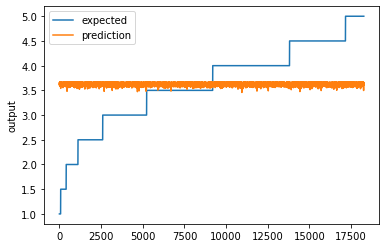

In [47]:
#Chart regression
chart_regression(pred.flatten(),y_test,sort=True)

In [48]:
print(pred)

[[3.6135366]
 [3.640924 ]
 [3.6044917]
 ...
 [3.644472 ]
 [3.5963364]
 [3.6386278]]
